In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
keras = tf.keras


2023-04-08 21:00:21.890923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
test = tf.data.Dataset.from_tensor_slices([1, 2, 3])

2023-04-08 21:00:31.505284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:


import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [75]:
Q_MEAN = 0.5
EPOCH = 2
POPULATION_SIZE = 500000
TRAIN_DIM = 100
STEP = 10
BATCH_NUM = 1
WINDOW_SIZE = 30

In [5]:

import numpy as np

def initialize_with_str_seed(init_str):
    """
    Initializes random number generator with seed corresponding to given input string init_str.
    :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                     values of each character in init_str.
    """
    rnd_val = 0
    if init_str:
        for c in init_str:
            rnd_val += ord(c)
    np.random.seed(rnd_val)

def gen_data(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

def gen_valid(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    
    n = int(n/10)
    
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y



In [6]:
import math

x_train, y_train = gen_data(POPULATION_SIZE, TRAIN_DIM)
x_valid, y_valid = gen_data(int(POPULATION_SIZE/500), TRAIN_DIM)


In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [85]:

def compile_and_fit_model(model, train_set, epoch_num = EPOCH, eager = False):

    
    lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"],
                run_eagerly = eager)

    history = model.fit(train_set, epochs = epoch_num, callbacks=[lr_schedule])
    return history

def eval_model(train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    batch_size = math.floor(train_size/STEP)
    # batch_size = 1
    train_set = tf.data.Dataset.from_tensor_slices((x_train[:train_size], y_train[:train_size])).batch(batch_size)

    ''' Compile and fit the empirical model as baseline'''
    # model = MechanizedSequential([
    #     keras.layers.Conv1D(filters = 32,
    #                         kernel_size = 5,
    #                         strides = 1, 
    #                         padding = "causal",
    #                         activation = "relu",
    #                         input_shape = [None, 1]),
    #     # keras.layers.LSTM(32, return_sequences = True,),
    #     # keras.layers.LSTM(32, return_sequences=True),
    #     keras.layers.Dense(1),
    #     keras.layers.Lambda(lambda x: x * 200)
    # ])   
    
    model = MechanizedSequential([
        keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[batch_size, None, 1]),
        keras.layers.LSTM(100, return_sequences=True, stateful=True),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 200.0)
        ]) 


    if not (mechanism.mechanism_type == Mechanism.MechanismType.NONE):
        model.choose_mech(mechanism)
        history = compile_and_fit_model(model, train_set, epoch_num, True)
    else:
        history = compile_and_fit_model(model, train_set, epoch_num, False)


    ''' Validate the result'''
    # x_valid, y_valid = gen_valid(POPULATION_SIZE, TRAIN_DIM)
    # model.choose_mech(None)
    valid_set = tf.data.Dataset.from_tensor_slices(x_valid).batch(batch_size)
    predict = model.predict(valid_set)
    
    error = generalization_error(y_valid, predict)
    return history, predict, error


def generalization_error(true_val, predict_val):
    error = keras.metrics.RootMeanSquaredError()
    error.update_state(true_val, predict_val)
    return error.result().numpy()



def eval_const_rounds(stepped_train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for n in stepped_train_size:
        history, predict, error = eval_model(train_size = n, epoch_num = epoch_num, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list




# Evaluate the Model

In [12]:


'''
Plot the Comparison of the Three Model
'''
def plot_error(rounds, generalization_error, mechanism, color = None):
    plt.plot(rounds, generalization_error, color, label = mechanism)
    plt.xlabel("Queries")
    plt.ylabel("RMSE (Generalization Error) for adaptive queries")
    plt.legend()
    plt.grid()


In [35]:
max_query_num = 1001
min_query_num = 1000
step = 50
stepped_query_num = range(min_query_num, max_query_num, step)

In [77]:
baseline_history_list, baseline_predict_list, baseline_generalization_error_list = eval_const_rounds(stepped_query_num)
print(baseline_generalization_error_list)

Epoch 1/2
10/10 [==============================] - 5s 220ms/step - loss: 4.3840 - mae: 4.8623 - lr: 1.0000e-08
Epoch 2/2
10/10 [==============================] - 1s 74ms/step
[6.0634027]


In [63]:
''' eval the empirical model as baseline'''
baseline_generalization_error_list = [eval_const_rounds(stepped_query_num)[2] for _ in range(100)]
print(np.mean(baseline_generalization_error_list, axis = 0))
"""
[13.719473]
[10.51995]
"""

Epoch 1/2
1000/1000 [==============================] - 31s 29ms/step - loss: 1.2912 - mae: 1.7313 - lr: 1.0000e-08
Epoch 2/2
1000/1000 [==============================] - 14s 13ms/step
Epoch 1/2
1000/1000 [==============================] - 35s 32ms/step - loss: 4.1995 - mae: 4.6773 - lr: 1.0000e-08
Epoch 2/2
1000/1000 [==============================] - 8s 7ms/step
Epoch 1/2
1000/1000 [==============================] - 33s 30ms/step - loss: 2.2725 - mae: 2.7347 - lr: 1.0000e-08
Epoch 2/2
1000/1000 [==============================] - 10s 9ms/step
Epoch 1/2
1000/1000 [==============================] - 33s 30ms/step - loss: 2.8567 - mae: 3.3258 - lr: 1.0000e-08
Epoch 2/2
1000/1000 [==============================] - 9s 8ms/step
Epoch 1/2
1000/1000 [==============================] - 27s 25ms/step - loss: 3.5728 - mae: 4.0473 - lr: 1.0000e-08
Epoch 2/2
1000/1000 [==============================] - 8s 8ms/step
Epoch 1/2
1000/1000 [==============================] - 31s 29ms/step - loss: 5.3173 - m

'\n[13.719473]\n[10.51995]\n'

In [12]:
print(np.mean(baseline_generalization_error_list))

50.823227


In [ ]:
_, _, gaussian_generalization_error_list = eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))
print((gaussian_generalization_error_list))
print(np.mean(gaussian_generalization_error_list))

In [64]:

gaussian_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2] for _ in range(10)]
print(np.mean(gaussian_generalization_error_list, axis = 0))

Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
   1/1000 [..............................] - ETA: 11:02 - loss: 2.0124 - mae: 2.4554In Gaussian Mechanism
Create Gaussian noise when accessing the training data
   2/1000 [..............................] - ETA: 9:15 - loss: 2.2160 - mae: 2.6784 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
   3/1000 [..............................] - ETA: 12:11 - loss: 2.2658 - mae: 2.7314In Gaussian Mechanism
Create Gaussian noise when accessing the training data
   4/1000 [..............................] - ETA: 11:27 - loss: 2.1927 - mae: 2.6590In Gaussian Mechanism
Create Gaussian noise when accessing the training data
   5/1000 [..............................] - ETA: 11:12 - loss: 2.0742 - mae: 2.5375In Gaussian Mechanism
Create Gaussian noise when accessing the training data
   6/1000 [..............................] - ETA: 11:03 - loss: 2.0629 - mae: 2.5263In Gaussian Mechanism
Cr

In [74]:
threshold_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.03, hold_frac = 0.5, threshold = 0.5))[2] for _ in range(10)]
print(np.mean(threshold_generalization_error_list, axis = 0))

Epoch 1/2
In Threshold out Mechanism
1000/1000 [==============================] - 657s 657ms/step - loss: 2.1018 - mae: 2.5616 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1000/1000 [==============================] - 178s 178ms/step
Epoch 1/2
In Threshold out Mechanism
1000/1000 [==============================] - 645s 645ms/step - loss: 1.6159 - mae: 2.0675 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1000/1000 [==============================] - 181s 180ms/step
Epoch 1/2
In Threshold out Mechanism
1000/1000 [==============================] - 693s 693ms/step - loss: 1.8971 - mae: 2.3573 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1000/1000 [==============================] - 212s 212ms/step
Epoch 1/2
In Threshold out Mechanism
1000/1000 [==============================] - 733s 733ms/step - loss: 2.4820 - mae: 2.9502 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1000/1000 [==============================] - 186s 186ms/step
Epoch 1/2
In Threshold out Mecha

In [133]:
import tensorflow as tf
# from cw_funcs import cw_funcs as cw
import numpy as np
from enum import Enum
import tensorflow_probability as tfp

Q_MEAN = 0.5


class Mechanism():
   class MechanismType(Enum):
        NONE = 0
        GAUSSIAN = 1
        DATASPLIT = 2
        THRESHOLD = 3

   def __init__(self, mechanism_type = MechanismType.NONE, mu = 0.0, sigma = 0.1, hold_frac = 0.5, threshold = 0.5, beta = None, tau = None, check_for_width = None):

        super().__init__()
        self.mechanism_type = mechanism_type
        '''
        Parameters for the Gaussian mechanism 
        '''
        self.mu = mu
        self.sigma = sigma

        '''
        Parameters for the GnC mechanism 
        '''      
        self.beta = beta
        self.tau = tau
        self.check_for_width = check_for_width


        '''
        Parameters for the Naive Data Splitting mechanism 
        '''
        self.split_size = None


        '''
        Parameters for the Thresholdout mechanism 
        '''
        self.hold_size = None
        self.train_size = None 
        assert 0.0 < hold_frac <= 1.0, "hold_frac should take a value in (0, 1]."
        self.hold_frac = hold_frac
        self.threshold = threshold
   
   def initialize_with_str_seed(self, init_str):
      """
      Initializes random number generator with seed corresponding to given input string init_str.
      :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                        values of each character in init_str.
      """
      rnd_val = 0
      if init_str:
         for c in init_str:
               rnd_val += ord(c)
      np.random.seed(rnd_val)


   def gen_data(self, n, d, seed = None):
      if seed:
         self.initialize_with_str_seed(seed)
      p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
      data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
      data_y = np.random.choice([0, 1], n, p=[1 -p, p])
      return data, data_y

   def gen_valid(self, n, d, seed = None):
      if seed:
         self.initialize_with_str_seed(seed)
      
      n = int(n/10)
      
      p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
      data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
      data_y = np.random.choice([0, 1], n, p=[1 -p, p])
      return data, data_y
   
   # def gen_batch(self):
   #    train_set = tf.data.Dataset.from_tensor_slices((x_train[:train_size], y_train[:train_size])).batch(batch_size)
   
   def gen_fresh_batch(self, data):
      x, y = data
      shape = tf.shape(x)
      n, d = shape[0], shape[1]
      data_x, data_y = self.gen_data(n, d)
      data_y = tf.cast(data_y, y.dtype)
      data_x =tf.cast(data_x, x.dtype)
      n = tf.cast(n, tf.int64)
      print(n.dtype)
      return tf.convert_to_tensor(data_x), tf.convert_to_tensor(data_y)




class MechanizedSequential(tf.keras.Sequential):


  def __init__(self, *args, **kwargs):
      super(MechanizedSequential, self).__init__(*args, **kwargs)
      self.mechanism = Mechanism(Mechanism.MechanismType.NONE)


      '''
      Parameters for the GnC mechanism 
      '''
      self.mu = 0.0
      self.sigma = 0.03

      '''
      Parameters for the GnC mechanism 
      '''      
      self.beta = None
      self.tau = None
      self.check_for_width = None   


      '''
      Parameters for the Naive Data Splitting mechanism 
      '''
      self.split_size = None


      '''
      Parameters for the Thresholdout mechanism 
      '''
      self.hold_size = None
      self.train_size = None
      self.hold_frac = None
      self.threshold = None
      self.noisy_thresh = None
      # self.mechanism.threshold + np.random.laplace(0, 2 * self.mechanism.sigma) if self.mechanism.mechanism_type == Mechanism.MechanismType.THRESHOLD else None
         
  def choose_mech(self, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
     self.mechanism = mechanism
     self.noisy_thresh = self.mechanism.threshold + np.random.laplace(0, 2 * self.mechanism.sigma) if self.mechanism.mechanism_type == Mechanism.MechanismType.THRESHOLD else None

  def set_gaussian_para(self, mu, sigma):
     return
     self.set_mechanism_para(mu, sigma)

  def set_mechanism_para(self, mu = 0.0, sigma = None, hold_frac = 0.5, threshold = 0.5, beta = None, tau = None, check_for_width = None):
      return
    
  def compute_metrics_gaussin(self, x, y, y_pred, sample_weight):
      x_noise = tf.random.normal(
            tf.shape(x),
            mean=self.mu,
            stddev=self.sigma,
            dtype=x.dtype,
            seed=None,
            name=None
            )
      
      noised_x = x_noise + x
  
      y_noise = tf.random.normal(
        tf.shape(y),
        mean=self.mechanism.mu,
        stddev=self.mechanism.sigma,
        dtype = y.dtype,
        seed=None,
        name=None
        )
      noised_y = y + y_noise

      self.compiled_metrics.update_state(noised_y, y_pred, sample_weight)

      metrics_results = super(MechanizedSequential, self).compute_metrics(
        noised_x, y, y_pred, sample_weight)
      return metrics_results
  
  def compute_metrics(self, x, y, y_pred, sample_weight):
      if self.mechanism is None:
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      elif self.mechanism.mechanism_type == Mechanism.MechanismType.GAUSSIAN:
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
         # return self.compute_metrics_gaussin(x, y, y_pred, sample_weight)
      else:
         self.compiled_metrics.update_state(y, y_pred, sample_weight)
         return super(MechanizedSequential, self).compute_metrics(
        x, y, y_pred, sample_weight)
      
  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      if self.mechanism is None:
        return super(MechanizedSequential, self).train_step(data)
      elif self.mechanism.mechanism_type == Mechanism.MechanismType.GAUSSIAN:
         print("In Gaussian Mechanism")
         return self.gaussian_train_step(data)
      elif self.mechanism.mechanism_type == Mechanism.MechanismType.DATASPLIT:
         print("In Naive Data Splitting Mechanism")
         return self.data_split_train_step(data)
      elif self.mechanism.mechanism_type == Mechanism.MechanismType.THRESHOLD:
         print("In Threshold out Mechanism")
         return self.thresholdout_train_step(data)
      else:
        return super(MechanizedSequential, self).train_step(data)

      
  
  def gaussian_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      with tf.GradientTape() as tape:
         print("Create Gaussian noise when accessing the training data")
         x_train = x
         y_pred_original = self(x_train, training=True)  # Forward pass
         y_noise =  tf.random.normal(
                  tf.shape(y_pred_original),
                  mean=self.mechanism.mu,
                  stddev=self.mechanism.sigma,
                  dtype=y_pred_original.dtype,
                  seed=None,
                  name=None
                  )
         y_pred = y_pred_original + y_noise

         
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  '''
  Naive Data Splitting Mechanism:
  Either splitting the data in smaller batch-size and train with more steps,
  or doing the same training steps as the one without any mechanism.
  This one is the version that is the same as the train_step without any mechanism.
  '''
  def data_split_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
 
      # x, y = self.mechanism.gen_fresh_batch(data)
      x, y = self.mechanism.gen_fresh_batch(data)
      print(x, y)
      # x, y = fresh_data
      with tf.GradientTape() as tape:
         print("In Naive Data Split")
         y_pred = self(x, training=True)  # Forward pass
         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}
  
  def thresholdout_train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data
      shape = tf.shape(x)
      length = shape[0]
      if(length > 1):
         hold_size, train_size = int(length  * (self.mechanism.hold_frac)), int(length  * (1.0 - self.mechanism.hold_frac))
         x_train, y_train, x_hold, y_hold = x[hold_size:], y[hold_size:], x[:hold_size], y[:hold_size]
      else:
         hold_size, train_size = length, length
         x_train, y_train, x_hold, y_hold = x, y, x, y
         
      with tf.GradientTape() as tape:

         y_pred_train = self(x_train, training=True)  # Forward pass
         y_pred_hold = self(x_hold, training = True)
         '''
         TODO: Need to consider one of the following model as one shot of query:
          model-1. one step of training, the result of the logistic is a query
          model-2. one step of training, the losse of the trained logistic v.s. the true logistic.
         '''

         '''
         model-1.
         drawback: the query result isn't unform data type, the trained logistic has different size dependents on the databse size.
         '''
         diff = (np.sum(y_pred_train.numpy(), axis = 0) / train_size - np.sum(y_pred_hold.numpy(), axis = 0) / hold_size)
         mean_abs_diff = np.absolute(diff).mean()
         if mean_abs_diff >= self.noisy_thresh + np.random.laplace(0, 4 * self.mechanism.sigma):
            self.noisy_thresh = self.mechanism.threshold + np.random.laplace(0, 2 * self.mechanism.sigma)
            y_true, y_pred = y_hold, y_pred_hold + tfp.distributions.Laplace(self.mechanism.mu, self.mechanism.sigma).sample(tf.shape(y_pred_hold))
            loss = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

         '''
         model-2:
         drawback: the "loss of  the trained logistic v.s. the true logistic" isn't a direct
          query on the data. 
         advantage: the losses in different steps or different size of database always have the same type.
         '''
         loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)
         loss_hold = self.compiled_loss(y_hold, y_pred_hold, regularization_losses=self.losses)

         if np.abs(loss - loss_hold) >= self.noisy_thresh + np.random.laplace(0, 4 * self.sigma):
            self.noisy_thresh = self.mechanism.threshold + np.random.laplace(0, 2 * self.sigma)

            loss = loss_hold + tfp.distributions.Laplace(self.mu, self.sigma).sample(tf.shape(loss_hold))
            # min(1.0, max(0.0, loss_hold + np.random.laplace(0, self.sigma)))
            y_true, y_pred = y_hold, y_pred_hold
         else:
            y_true, y_pred = y_train, y_pred_train
            loss = self.compiled_loss(y_train, y_pred_train, regularization_losses=self.losses)

      
      
      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update metrics (includes the metric that tracks the loss)
      self.compiled_metrics.update_state(y_true, y_pred)

      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

In [134]:
data_split_error_list = eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.DATASPLIT, sigma = 0.03))


Epoch 1/2
In Naive Data Splitting Mechanism
<dtype: 'int64'>
tf.Tensor(
[[-1  1  1 ...  1 -1  1]
 [-1 -1  1 ... -1  1 -1]
 [-1 -1  1 ... -1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [ 1 -1  1 ... -1 -1  1]
 [-1  1 -1 ...  1  1  1]], shape=(100, 100), dtype=int64) tf.Tensor(
[1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1
 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0
 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1], shape=(100,), dtype=int64)
In Naive Data Split
 1/10 [==>...........................] - ETA: 9s - loss: 1.0431 - mae: 1.4732In Naive Data Splitting Mechanism
<dtype: 'int64'>
tf.Tensor(
[[-1  1 -1 ... -1  1  1]
 [ 1  1  1 ... -1 -1  1]
 [ 1 -1  1 ... -1 -1  1]
 ...
 [ 1 -1 -1 ... -1  1  1]
 [-1  1 -1 ... -1 -1  1]
 [ 1  1 -1 ... -1  1 -1]], shape=(100, 100), dtype=int64) tf.Tensor(
[1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1

In [78]:
data_split_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.DATASPLIT, sigma = 0.03))[2] for _ in range(10)]
print(np.mean(data_split_error_list, axis = 0))

Epoch 1/2
In Naive Data Splitting Mechanism


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:

''' Compile and fit the threshold out model'''
threshold_history_list, threshold_predict_list, threshold_generalization_error_list = eval_const_rounds(stepped_train_size = stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.7, threshold = 0.5))
print(threshold_generalization_error_list)
print(np.mean(threshold_generalization_error_list))
"""
[3.270109] 
"""


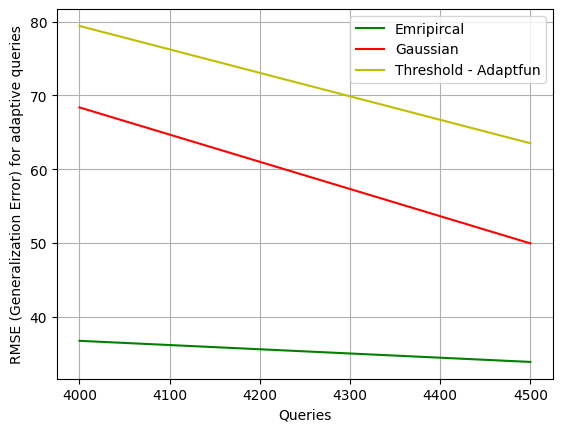

In [19]:

""" plot the generalization error """
plt.figure()
x_range = stepped_query_num
plot_error(x_range, (baseline_generalization_error_list), "Emripircal", 'g')
plot_error(x_range, (gaussian_generalization_error_list), "Gaussian", 'r')
plot_error(x_range, (threshold_generalization_error_list), "Threshold - Adaptfun", "y")
plt.savefig("../plots/n_adaptivity.png")
plt.show()

# Evaluate the O(n) adaptivity

In [26]:

def eval_multiple_rounds(train_size, stepped_epoch_num, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for r in stepped_epoch_num:
        history, predict, error = eval_model(train_size = train_size, epoch_num = r, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list

In [46]:
max_query_num = 500
max_rounds = 1000
stepped_rounds = range(700, max_rounds, 100)

In [47]:
''' eval the empirical model as baseline'''
baseline_history_list, baseline_predict_list, baseline_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds)
print(baseline_generalization_error_list)

Epoch 1/700
1/1 [==============================] - 1s 1s/step - loss: 57.5840 - mae: 58.0839 - lr: 1.0000e-08
Epoch 2/700
1/1 [==============================] - 0s 334ms/step - loss: 57.5836 - mae: 58.0835 - lr: 1.1220e-08
Epoch 3/700
1/1 [==============================] - 0s 338ms/step - loss: 57.5826 - mae: 58.0825 - lr: 1.2589e-08
Epoch 4/700
1/1 [==============================] - 0s 332ms/step - loss: 57.5812 - mae: 58.0811 - lr: 1.4125e-08
Epoch 5/700
1/1 [==============================] - 0s 331ms/step - loss: 57.5792 - mae: 58.0791 - lr: 1.5849e-08
Epoch 6/700
1/1 [==============================] - 0s 349ms/step - loss: 57.5767 - mae: 58.0766 - lr: 1.7783e-08
Epoch 7/700
1/1 [==============================] - 0s 362ms/step - loss: 57.5736 - mae: 58.0735 - lr: 1.9953e-08
Epoch 8/700
1/1 [==============================] - 0s 366ms/step - loss: 57.5698 - mae: 58.0697 - lr: 2.2387e-08
Epoch 9/700
1/1 [==============================] - 0s 327ms/step - loss: 57.5654 - mae: 58.0653 - l

Epoch 1/800
1/1 [==============================] - 1s 788ms/step - loss: 39.9407 - mae: 40.4352 - lr: 1.0000e-08
Epoch 2/800
1/1 [==============================] - 0s 375ms/step - loss: 39.9404 - mae: 40.4350 - lr: 1.1220e-08
Epoch 3/800
1/1 [==============================] - 0s 364ms/step - loss: 39.9400 - mae: 40.4346 - lr: 1.2589e-08
Epoch 4/800
1/1 [==============================] - 0s 371ms/step - loss: 39.9393 - mae: 40.4339 - lr: 1.4125e-08
Epoch 5/800
1/1 [==============================] - 0s 359ms/step - loss: 39.9383 - mae: 40.4329 - lr: 1.5849e-08
Epoch 6/800
1/1 [==============================] - 0s 343ms/step - loss: 39.9371 - mae: 40.4318 - lr: 1.7783e-08
Epoch 7/800
1/1 [==============================] - 0s 351ms/step - loss: 39.9357 - mae: 40.4303 - lr: 1.9953e-08
Epoch 8/800
1/1 [==============================] - 0s 358ms/step - loss: 39.9338 - mae: 40.4285 - lr: 2.2387e-08
Epoch 9/800
1/1 [==============================] - 0s 359ms/step - loss: 39.9317 - mae: 40.4264 

Epoch 1/900
1/1 [==============================] - 1s 767ms/step - loss: 43.2185 - mae: 43.7130 - lr: 1.0000e-08
Epoch 2/900
1/1 [==============================] - 0s 340ms/step - loss: 43.2182 - mae: 43.7127 - lr: 1.1220e-08
Epoch 3/900
1/1 [==============================] - 0s 352ms/step - loss: 43.2177 - mae: 43.7122 - lr: 1.2589e-08
Epoch 4/900
1/1 [==============================] - 0s 368ms/step - loss: 43.2169 - mae: 43.7113 - lr: 1.4125e-08
Epoch 5/900
1/1 [==============================] - 0s 348ms/step - loss: 43.2157 - mae: 43.7102 - lr: 1.5849e-08
Epoch 6/900
1/1 [==============================] - 0s 329ms/step - loss: 43.2143 - mae: 43.7088 - lr: 1.7783e-08
Epoch 7/900
1/1 [==============================] - 0s 378ms/step - loss: 43.2125 - mae: 43.7070 - lr: 1.9953e-08
Epoch 8/900
1/1 [==============================] - 0s 335ms/step - loss: 43.2104 - mae: 43.7049 - lr: 2.2387e-08
Epoch 9/900
1/1 [==============================] - 0s 357ms/step - loss: 43.2079 - mae: 43.7024 

In [48]:
''' Compile and fit the gaussian model'''
gaussian_history_list, gaussian_preditc_list, gaussian_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))

Epoch 1/700
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 817ms/step - loss: 28.0037 - mae: 28.5035 - lr: 1.0000e-08
Epoch 2/700
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 748ms/step - loss: 28.0038 - mae: 28.5036 - lr: 1.1220e-08
Epoch 3/700
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 748ms/step - loss: 28.0035 - mae: 28.5033 - lr: 1.2589e-08
Epoch 4/700
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 733ms/step - loss: 28.0031 - mae: 28.5029 - lr: 1.4125e-08
Epoch 5/700
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 754ms/step - loss: 28.0025 - mae: 28.5023 - lr: 1.5849e-08
Epoch 6/700
In Gaussian Mechanism
Create Gaussian 

Epoch 1/800
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 1s/step - loss: 33.2697 - mae: 33.7668 - lr: 1.0000e-08
Epoch 2/800
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 814ms/step - loss: 33.2696 - mae: 33.7667 - lr: 1.1220e-08
Epoch 3/800
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 836ms/step - loss: 33.2690 - mae: 33.7661 - lr: 1.2589e-08
Epoch 4/800
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 752ms/step - loss: 33.2684 - mae: 33.7655 - lr: 1.4125e-08
Epoch 5/800
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 686ms/step - loss: 33.2673 - mae: 33.7644 - lr: 1.5849e-08
Epoch 6/800
In Gaussian Mechanism
Create Gaussian noi

Epoch 1/900
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 779ms/step - loss: 34.9519 - mae: 35.4487 - lr: 1.0000e-08
Epoch 2/900
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 939ms/step - loss: 34.9518 - mae: 35.4487 - lr: 1.1220e-08
Epoch 3/900
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 977ms/step - loss: 34.9513 - mae: 35.4481 - lr: 1.2589e-08
Epoch 4/900
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 809ms/step - loss: 34.9506 - mae: 35.4474 - lr: 1.4125e-08
Epoch 5/900
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 1s 748ms/step - loss: 34.9496 - mae: 35.4464 - lr: 1.5849e-08
Epoch 6/900
In Gaussian Mechanism
Create Gaussian 

In [49]:
print(gaussian_generalization_error_list)

[inf, inf, nan]


In [50]:

''' Compile and fit the threshold out model'''
threshold_history_list, threshold_predict_list, threshold_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.4, threshold = 0.5))
print(threshold_generalization_error_list)

Epoch 1/700
In Threshold out Mechanism
1/1 [==============================] - 0s 374ms/step - loss: 61.7763 - mae: 62.6778 - lr: 1.0000e-08
Epoch 2/700
In Threshold out Mechanism
1/1 [==============================] - 1s 799ms/step - loss: 61.7433 - mae: 62.2056 - lr: 1.1220e-08
Epoch 3/700
In Threshold out Mechanism
1/1 [==============================] - 0s 296ms/step - loss: 61.7737 - mae: 62.6752 - lr: 1.2589e-08
Epoch 4/700
In Threshold out Mechanism
1/1 [==============================] - 1s 808ms/step - loss: 61.7390 - mae: 62.2013 - lr: 1.4125e-08
Epoch 5/700
In Threshold out Mechanism
1/1 [==============================] - 0s 273ms/step - loss: 61.7675 - mae: 62.6691 - lr: 1.5849e-08
Epoch 6/700
In Threshold out Mechanism
1/1 [==============================] - 0s 298ms/step - loss: 61.7630 - mae: 62.6646 - lr: 1.7783e-08
Epoch 7/700
In Threshold out Mechanism
1/1 [==============================] - 0s 325ms/step - loss: 61.7575 - mae: 62.6590 - lr: 1.9953e-08
Epoch 8/700
In Thres

Epoch 1/800
In Threshold out Mechanism
1/1 [==============================] - 1s 830ms/step - loss: 30.8209 - mae: 31.2982 - lr: 1.0000e-08
Epoch 2/800
In Threshold out Mechanism
1/1 [==============================] - 1s 827ms/step - loss: 30.8205 - mae: 31.2977 - lr: 1.1220e-08
Epoch 3/800
In Threshold out Mechanism
1/1 [==============================] - 1s 836ms/step - loss: 30.8195 - mae: 31.2968 - lr: 1.2589e-08
Epoch 4/800
In Threshold out Mechanism
1/1 [==============================] - 1s 853ms/step - loss: 30.8181 - mae: 31.2953 - lr: 1.4125e-08
Epoch 5/800
In Threshold out Mechanism
1/1 [==============================] - 0s 316ms/step - loss: 30.8317 - mae: 31.5228 - lr: 1.5849e-08
Epoch 6/800
In Threshold out Mechanism
1/1 [==============================] - 1s 823ms/step - loss: 30.8136 - mae: 31.2908 - lr: 1.7783e-08
Epoch 7/800
In Threshold out Mechanism
1/1 [==============================] - 1s 834ms/step - loss: 30.8105 - mae: 31.2877 - lr: 1.9953e-08
Epoch 8/800
In Thres

/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


1/1 [==============================] - 1s 881ms/step - loss: inf - mae: inf - lr: 22387212319743359777827788423168.0000
Epoch 789/800
In Threshold out Mechanism
1/1 [==============================] - 1s 780ms/step - loss: inf - mae: inf - lr: 25118864833969987422118622527488.0000
Epoch 790/800
In Threshold out Mechanism
1/1 [==============================] - 1s 849ms/step - loss: inf - mae: inf - lr: 28183830285922564476167696416768.0000
Epoch 791/800
In Threshold out Mechanism
1/1 [==============================] - 1s 825ms/step - loss: inf - mae: inf - lr: 31622776940172927065412125851648.0000
Epoch 792/800
In Threshold out Mechanism


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1/1 [==============================] - 1s 837ms/step - loss: inf - mae: inf - lr: 35481339328559888211938719563776.0000
Epoch 793/800
In Threshold out Mechanism
1/1 [==============================] - 1s 856ms/step - loss: inf - mae: inf - lr: 39810717877395766690554633519104.0000
Epoch 794/800
In Threshold out Mechanism
1/1 [==============================] - 1s 851ms/step - loss: inf - mae: inf - lr: 44668358323777010450383555788800.0000
Epoch 795/800
In Threshold out Mechanism
1/1 [==============================] - 1s 818ms/step - loss: inf - mae: inf - lr: 50118723010257110748279169089536.0000
Epoch 796/800
In Threshold out Mechanism
1/1 [==============================] - 1s 810ms/step - loss: inf - mae: inf - lr: 56234132297217053930730746281984.0000
Epoch 797/800
In Threshold out Mechanism
1/1 [==============================] - 1s 810ms/step - loss: inf - mae: inf - lr: 63095734121372652366461264723968.0000
Epoch 798/800
In Threshold out Mechanism
1/1 [=============================

Epoch 1/900
In Threshold out Mechanism
1/1 [==============================] - 1s 794ms/step - loss: 23.9922 - mae: 24.4594 - lr: 1.0000e-08
Epoch 2/900
In Threshold out Mechanism
1/1 [==============================] - 1s 805ms/step - loss: 23.9919 - mae: 24.4592 - lr: 1.1220e-08
Epoch 3/900
In Threshold out Mechanism
1/1 [==============================] - 0s 301ms/step - loss: 24.0121 - mae: 24.7604 - lr: 1.2589e-08
Epoch 4/900
In Threshold out Mechanism
1/1 [==============================] - 0s 285ms/step - loss: 24.0114 - mae: 24.7597 - lr: 1.4125e-08
Epoch 5/900
In Threshold out Mechanism
1/1 [==============================] - 1s 769ms/step - loss: 23.9899 - mae: 24.4571 - lr: 1.5849e-08
Epoch 6/900
In Threshold out Mechanism
1/1 [==============================] - 0s 302ms/step - loss: 24.0092 - mae: 24.7576 - lr: 1.7783e-08
Epoch 7/900
In Threshold out Mechanism
1/1 [==============================] - 1s 792ms/step - loss: 23.9872 - mae: 24.4544 - lr: 1.9953e-08
Epoch 8/900
In Thres

/var/folders/_j/z7zdrth14_s3bcxmp4glxrw40000gp/T/ipykernel_36974/1855233911.py:225: RuntimeWarning: invalid value encountered in subtract
  diff = (np.sum(y_pred_train.numpy(), axis = 0) / train_size - np.sum(y_pred_hold.numpy(), axis = 0) / hold_size)


1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 398107164266847831529996238716928.0000
Epoch 814/900
In Threshold out Mechanism
1/1 [==============================] - 1s 867ms/step - loss: inf - mae: inf - lr: 446683583237770104503835557888000.0000
Epoch 815/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 501187220431164550565758293245952.0000
Epoch 816/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 562341342314983653141374258118656.0000
Epoch 817/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 630957341213726523664612647239680.0000
Epoch 818/900
In Threshold out Mechanism
1/1 [==============================] - 1s 1s/step - loss: inf - mae: inf - lr: 707945799397540014663928947671040.0000
Epoch 819/900
In Threshold out Mechanism
1/1 [==============================] - 1s 9

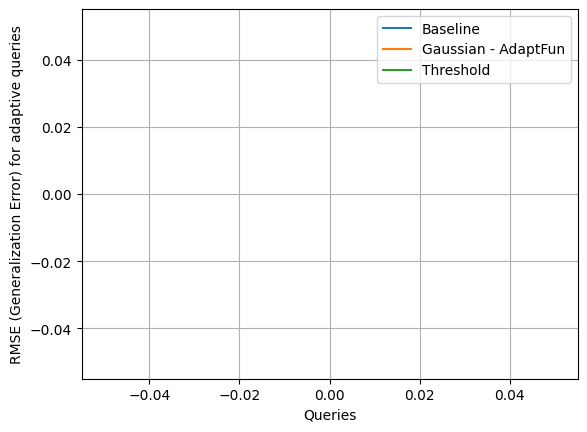

In [52]:

""" plot the generalization error """
plt.figure()
plot_error(stepped_rounds, baseline_generalization_error_list, "Baseline")
plot_error(stepped_rounds, gaussian_generalization_error_list, "Gaussian - AdaptFun")
plot_error(stepped_rounds, threshold_generalization_error_list, "Threshold")
plt.show()

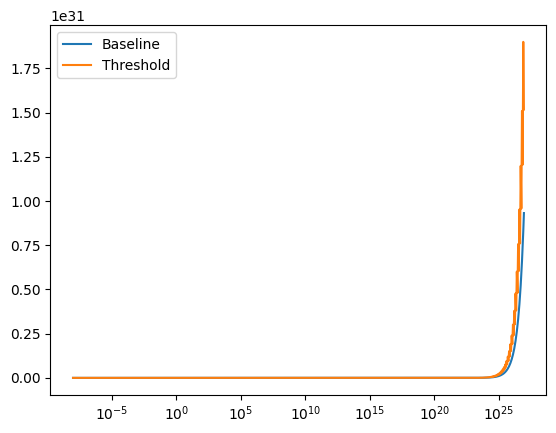

In [56]:
plt.semilogx(baseline_history_list[0].history["lr"], baseline_history_list[0].history["loss"], label = "Baseline")
# plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history_list[0].history["lr"], threshold_history_list[0].history["loss"], label = "Threshold")

plt.legend()